In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [4]:
train_dir = "../train" #passing the path with training images
test_dir = "../test"   #passing the path with testing images

In [5]:
img_size = 48

In [6]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [7]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                                                         )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [10]:
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

In [9]:
len(train_generator)

359

In [55]:

# Store the data in X_train, y_train variables by iterating over the batches
train_generator.reset()
X_train, y_train = next(train_generator)
for i in range(int(len(train_generator))-1): #1st batch is already fetched before the for loop.
    img, label = next(train_generator)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

(22968, 48, 48, 1) (22968, 7)


In [56]:
X_train.shape

(22968, 48, 48, 1)

In [57]:
y_train.shape

(22968, 7)

In [11]:
X_test.shape

(64, 48, 48, 1)

In [12]:
y_test.shape

(64, 7)

In [41]:
class_names = train_generator.class_indices

class_names_swap = {v: k for k, v in class_names.items()}
print(class_names_swap)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [3]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np 

r = random.sample(range(X_train.shape[0]), 14)
for i in range(14):
    plt.subplot(2, 7, i+1)
    plt.imshow(X_train[r[i]],'gray')
    plt.title(class_names_swap[np.argmax(y_train[r[i]])])
    plt.axis("off")    

NameError: name 'X_train' is not defined

In [60]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))
# model.fit_generator(..., class_weight=train_class_weights)

In [61]:
train_class_weights

{0: 1.0266404434114071,
 1: 9.401555464592715,
 2: 1.0009587727708533,
 3: 0.5684585684585685,
 4: 0.826068191627104,
 5: 0.8491570541259982,
 6: 1.2933160650937552}

In [62]:
class_names_swap

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [64]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [65]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [66]:
def ResNet34(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [95]:
def light_model(shape = (32, 32, 3), classes = 10):
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(256, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "light_model")
    return model

In [96]:
model = ResNet34(shape = (48, 48, 1), classes = 7)

epochs = 60
batch_size = 64
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 54, 54, 1)   0           ['input_11[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv2d_338 (Conv2D)            (None, 27, 27, 64)   3200        ['zero_padding2d_10[0][0]']      
                                                                                                  
 batch_normalization_326 (Batch  (None, 27, 27, 64)  256         ['conv2d_338[0][0]']      

 add_161 (Add)                  (None, 7, 7, 128)    0           ['batch_normalization_334[0][0]',
                                                                  'conv2d_347[0][0]']             
                                                                                                  
 activation_334 (Activation)    (None, 7, 7, 128)    0           ['add_161[0][0]']                
                                                                                                  
 conv2d_348 (Conv2D)            (None, 7, 7, 128)    147584      ['activation_334[0][0]']         
                                                                                                  
 batch_normalization_335 (Batch  (None, 7, 7, 128)   512         ['conv2d_348[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_344 (Batch  (None, 4, 4, 256)   1024        ['conv2d_358[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_166 (Add)                  (None, 4, 4, 256)    0           ['batch_normalization_344[0][0]',
                                                                  'activation_342[0][0]']         
                                                                                                  
 activation_344 (Activation)    (None, 4, 4, 256)    0           ['add_166[0][0]']                
                                                                                                  
 conv2d_359 (Conv2D)            (None, 4, 4, 256)    590080      ['activation_344[0][0]']         
          

                                                                                                  
 conv2d_368 (Conv2D)            (None, 2, 2, 512)    2359808     ['activation_353[0][0]']         
                                                                                                  
 batch_normalization_354 (Batch  (None, 2, 2, 512)   2048        ['conv2d_368[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_369 (Conv2D)            (None, 2, 2, 512)    131584      ['activation_352[0][0]']         
                                                                                                  
 add_171 (Add)                  (None, 2, 2, 512)    0           ['batch_normalization_354[0][0]',
                                                                  'conv2d_369[0][0]']             
          

In [97]:
light_model =  light_model(shape = (48, 48, 1), classes = 7)
light_model.summary()

Model: "light_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d_11 (ZeroPadding  (None, 54, 54, 1)   0           ['input_12[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv2d_374 (Conv2D)            (None, 27, 27, 64)   3200        ['zero_padding2d_11[0][0]']      
                                                                                                  
 batch_normalization_359 (Batch  (None, 27, 27, 64)  256         ['conv2d_374[0][0]']   

                                                                                                  
 activation_367 (Activation)    (None, 14, 14, 64)   0           ['add_177[0][0]']                
                                                                                                  
 conv2d_383 (Conv2D)            (None, 14, 14, 64)   36928       ['activation_367[0][0]']         
                                                                                                  
 batch_normalization_368 (Batch  (None, 14, 14, 64)  256         ['conv2d_383[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_368 (Activation)    (None, 14, 14, 64)   0           ['batch_normalization_368[0][0]']
                                                                                                  
 conv2d_38

 add_182 (Add)                  (None, 14, 14, 64)   0           ['batch_normalization_377[0][0]',
                                                                  'activation_375[0][0]']         
                                                                                                  
 activation_377 (Activation)    (None, 14, 14, 64)   0           ['add_182[0][0]']                
                                                                                                  
 conv2d_393 (Conv2D)            (None, 14, 14, 64)   36928       ['activation_377[0][0]']         
                                                                                                  
 batch_normalization_378 (Batch  (None, 14, 14, 64)  256         ['conv2d_393[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 add_187 (Add)                  (None, 14, 14, 64)   0           ['batch_normalization_387[0][0]',
                                                                  'activation_385[0][0]']         
                                                                                                  
 activation_387 (Activation)    (None, 14, 14, 64)   0           ['add_187[0][0]']                
                                                                                                  
 conv2d_403 (Conv2D)            (None, 14, 14, 64)   36928       ['activation_387[0][0]']         
                                                                                                  
 batch_normalization_388 (Batch  (None, 14, 14, 64)  256         ['conv2d_403[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_397 (Batch  (None, 14, 14, 64)  256         ['conv2d_412[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_192 (Add)                  (None, 14, 14, 64)   0           ['batch_normalization_397[0][0]',
                                                                  'activation_395[0][0]']         
                                                                                                  
 activation_397 (Activation)    (None, 14, 14, 64)   0           ['add_192[0][0]']                
                                                                                                  
 conv2d_413 (Conv2D)            (None, 14, 14, 64)   36928       ['activation_397[0][0]']         
          

                                                                                                  
 conv2d_422 (Conv2D)            (None, 14, 14, 64)   36928       ['activation_406[0][0]']         
                                                                                                  
 batch_normalization_407 (Batch  (None, 14, 14, 64)  256         ['conv2d_422[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_197 (Add)                  (None, 14, 14, 64)   0           ['batch_normalization_407[0][0]',
                                                                  'activation_405[0][0]']         
                                                                                                  
 activation_407 (Activation)    (None, 14, 14, 64)   0           ['add_197[0][0]']                
          

In [98]:
light_model.compile(
    optimizer = 'adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [99]:
import scipy.integrate

import scipy.special
import scipy

history = light_model.fit(x = train_generator,epochs = 10,batch_size=batch_size,validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/10
359/359 [==============================] - 662s 2s/step - loss: 2.8541 - accuracy: 0.1853 - val_loss: 1.9024 - val_accuracy: 0.2479
Epoch 2/10
359/359 [==============================] - 1094s 3s/step - loss: 1.8297 - accuracy: 0.2683 - val_loss: 1.6869 - val_accuracy: 0.3387
Epoch 3/10
359/359 [==============================] - 1068s 3s/step - loss: 1.7239 - accuracy: 0.3292 - val_loss: 1.6298 - val_accuracy: 0.3324
Epoch 4/10
359/359 [==============================] - 924s 3s/step - loss: 1.6231 - accuracy: 0.3749 - val_loss: 2.1206 - val_accuracy: 0.1885
Epoch 5/10
359/359 [==============================] - 889s 2s/step - loss: 1.5642 - accuracy: 0.4006 - val_loss: 2.0483 - val_accuracy: 0.2158
Epoch 6/10
359/359 [==============================] - 882s 2s/step - loss: 1.4890 - accuracy: 0.4250 - val_loss: 1.6280 - val_accuracy: 0.3547
Epoch 7/10
359/359 [==============================] - 885s 2s/step - loss: 1.4443 - accuracy: 0.4465 - val_loss: 1.4610 - val_accuracy: 0.43

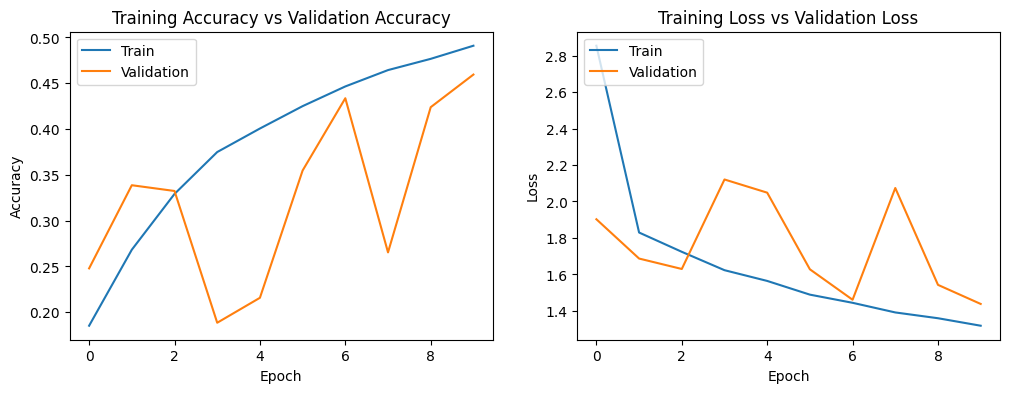

In [100]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [101]:
light_model.save('light_model.h5')